# Scrambling of operators

In [3]:
using ITensors
using ITensorTDVP
using Plots
using Observers
using LinearAlgebra
using ColorSchemes

In [4]:
N  = 21    # Number of spins
J  = 1.0    # ZZ interaction strength
hx = 1.05   # X-field 
hz = 0.5    # Z-field
δt = 0.5   # Time-step for evolution
δt_short = 0.005
T  = 10.0   # Total time
χ  = 32;    # Max link dimension allowed

## Extended system + ancilla

In [5]:
sitesext = siteinds("S=1/2",2*N); # Make 2N S=1/2 spin indices defining system + ancilla


In [6]:
# Extract the raising, lowering and identity operators for the extended system:

Sp = ops(sitesext, [("S+", n) for n in 1:(2*N)]);  # Raising operators
Sm = ops(sitesext, [("S-", n) for n in 1:(2*N)]);  # Lowering operators


# ITensors doesn't include the identity operator as standard so construct it:
Id = Vector{ITensor}(undef,2*N)
for i =1:(2*N)
    iv = sitesext[i]
    ID = ITensor(iv', dag(iv));
    for j in 1:ITensors.dim(iv)
        ID[iv' => j, iv => j] = 1.0
    end
    Id[i] = ID
end;

In [7]:
# Construct the identity vacuum state:

Ivac = MPS(sitesext, "0") # All 0 spins
# Ivac = MPS(sitesext, "Up") # All up spins initial state
# 1:2:(2*N) from 1 to 2N in steps of 2
######################################################
# Write code that takes dim and writes Ivac
######################################################
# (I-Z)/2 to spin chain should give same as applying n to bosons
#####

gates = [(Id[n]*Id[n+1] + Sm[n]*Sm[n+1]) for n in 1:2:(2*N)];
Ivac = apply(gates, Ivac; cutoff=1e-15); # Note we have no 1/sqrt(2) normalisation

In [8]:
# Vectorisation approach used here is to stack matrix rows into a column vector.
# This means that:
# vec(AB) = A ⊗ I vec(B) =  I ⊗ B^T vec(A)
# so |i><j| => |i> ⊗ |j>
# vec(L A R) = L ⊗ R^T vec(A)

# Define "Commutator" Hamiltonian operator terms:

# HC = H ⊗ I - I ⊗ H, since H is real and hermitian H = H^T.

H_op = OpSum()
for i=1:2*(N-1)
    H_op += (-1)^(i-1) *  J,"Sz",i,"Sz",i+2
end
for i=1:2*N
    H_op += (-1)^(i-1) *  hx,"Sx",i
    H_op += (-1)^(i-1) *  hz,"Sz",i
end



# Convert these terms to an MPO
HC = MPO(H_op,sitesext);

In [9]:
# Define observable for scrambling:

A_op = OpSum()
A_op += 1.0,"Sx",2*floor(Int,N/2+1)-1  # Sx operator in the middle of the system
A = MPO(A_op,sitesext);                # Build the MPO from these terms
Avec = apply(A, Ivac; cutoff=1e-15); 
;  # Compute |A> = A|I>
#put adag + a

## Perform TDVP time evolution of the operator

In [10]:
# Define function for computing entanglement entropy

function entanglement_entropy(ψ)
# Compute the von Neumann entanglement entropy across each bond of the MPS
    N = length(ψ)
    SvN = zeros(N)
    psi = ψ
    for b=1:N
        psi = orthogonalize(psi, b)
        if b==1
            U,S,V = svd(psi[b] , siteind(psi, b))
        else
            U,S,V = svd(psi[b], (linkind(psi, b-1), siteind(psi, b)))
        end
        p = diag(S).^2               # Extract square of Schmidt coefficients
        p = p ./ sum(p)              # Normalise to a probability dist
        SvN[b] = -sum(p .* log2.(p)) # Compute Shannon entropy
    end
    return SvN
end;

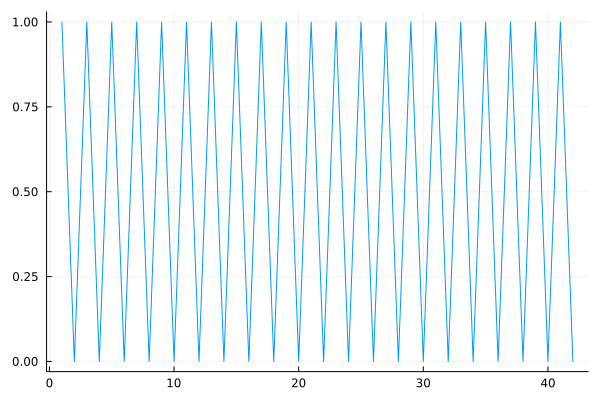

In [11]:
SvN_init = entanglement_entropy(Avec);
plot(1:(2*N), SvN_init, label=false) 

Here $|A>$ displays the entanglement structure of the initial vacuum state.

In [12]:
# Define observer functions for TDVP:

function current_time(; current_time, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return real(-im*current_time)
  end
    
  return nothing
end

function measure_SvN(; psi, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return entanglement_entropy(psi)
  end
  return nothing
end;

function measure_linkdim(; psi, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return maxlinkdim(psi)
  end
  return nothing
end;

# Define function that calulates the commutator 
function compute_commutator(ψ,Sx_r_system,Sx_r_ancilla)
  Sx_a= apply(Sx_r_system,ψ;cutoff=1e-15)
  a_Sx= apply(Sx_r_ancilla,ψ;cutoff=1e-15)

  return Sx_a - a_Sx
end;

function local_op(N,sitesext;r) #function used to define local operator to track C(r,t)
  # require r < floor(Int, N/2) 
  site_index= 2*floor(Int,N/2+1)+2*r-1 #defining site index
  Sx_r_system= op("Sx", sitesext, site_index)
  Sx_r_ancilla= op("Sx", sitesext, site_index+1)
  
  return Sx_r_system, Sx_r_ancilla
end;

function measure_commutator(; psi, bond, half_sweep)
  Sx_5_system, Sx_5_ancilla= local_op(N,sitesext;r=5)
  Sx_10_system, Sx_10_ancilla= local_op(N,sitesext;r=5)
  Sx_20_system, Sx_20_ancilla= local_op(N,sitesext;r=5)
  Sx_30_system, Sx_30_ancilla= local_op(N,sitesext;r=5)
  Sx_40_system, Sx_40_ancilla= local_op(N,sitesext;r=5)
  Sx_50_system, Sx_50_ancilla= local_op(N,sitesext;r=5)


  if bond == 1 && half_sweep == 2
    commutator_5 = compute_commutator(psi, Sx_5_system, Sx_5_ancilla)
    commutator_10 = compute_commutator(psi, Sx_10_system, Sx_10_ancilla)  
    commutator_20 = compute_commutator(psi, Sx_20_system, Sx_20_ancilla)
    commutator_30 = compute_commutator(psi, Sx_30_system, Sx_30_ancilla)
    commutator_40 = compute_commutator(psi, Sx_40_system, Sx_40_ancilla)
    commutator_50 = compute_commutator(psi, Sx_50_system, Sx_50_ancilla)


  return [real.(inner(commutator_5, commutator_5)), real.(inner(commutator_10, commutator_10)),
            real.(inner(commutator_20, commutator_20)), real.(inner(commutator_30, commutator_30)),
            real.(inner(commutator_40, commutator_40)),  real.(inner(commutator_50, commutator_50))]

  end
  return nothing

end;

In [13]:
# XX + YY spin hamiltonian
# killing of the spin at middle site
# map bosonic operators to spin operators
# annihilation is 1 on bottom, 0 on diagonal
# analytically solvable
# map to fermions, jordan-wigner transformations
# expect trivial solution as integrable, operator complexity bounded by a adag

# similar to ising model
# render as free fermi system
# solvable 

# try XX + YY model using heisenberg, confirm trivial

# bosonic operators annihiate one term from superposition
# Sx, Sz doesnt
# z nonzero, doesnt destroy entanglement


In [14]:
# Perform TDVP evolution of |A(t)>:

obs = Observer("times" => current_time, "SvN" => measure_SvN, "chi" => measure_linkdim,"Commutator"=>measure_commutator)

# d|A(t)>/dt = i HC |A(t)> so |A(t)> = exp(i t HC)|A(0)> 

# long time steps until time = 3.0
# short between time = 3.0 and 5.0
# long after time = 5.0

ψinit = tdvp(HC, im * 3.0, Avec; 
          time_step = im * δt,
          normalize = false, 
          maxdim = χ,
          cutoff = 1e-10,
          outputlevel=1)

ψshort = tdvp(HC, im * (5.0-3.0), ψinit; 
        time_step = im * δt_short,
        normalize = false, 
        maxdim = χ,
        cutoff = 1e-10,
        outputlevel=1,
        (observer!)=obs)

ψfinal = tdvp(HC, im * (T-5.0), ψshort; 
            time_step = im * δt,
            normalize = false, 
            maxdim = χ,
            cutoff = 1e-10,
            outputlevel=1)

# Extract results from time-step observations
#`observer.name` or `observer[!, "name"]`
#res = results(obs)
times = obs.times
SvN = obs.SvN
chi = obs.chi
Commutator=obs.Commutator


;
# times = res["times"]
# SvN = res["SvN"]
# chi = res["chi"];

After sweep 1: maxlinkdim=6

 maxerr=7.85E-11

 current_time=0.0 + 0.5im time=35.616


After sweep 2: maxlinkdim=8 maxerr=7.57E-11 current_time=0.0 + 1.0im time=0.778


After sweep 3: maxlinkdim=9 maxerr=9.87E-11 current_time=0.0 + 1.5im time=0.495


After sweep 4: maxlinkdim=13 maxerr=9.60E-11 current_time=0.0 + 2.0im time=0.606


After sweep 5: maxlinkdim=17 maxerr=8.58E-11 current_time=0.0 + 2.5im time=0.768


After sweep 6: maxlinkdim=22 maxerr=9.75E-11 current_time=0.0 + 3.0im time=1.078


After sweep 1: maxlinkdim=22 maxerr=5.99E-14 current_time=0.0 + 0.005im time=16.236


After sweep 2: maxlinkdim=22 maxerr=6.23E-14 current_time=0.0 + 0.01im time=1.016


After sweep 3: maxlinkdim=22 maxerr=6.47E-14 current_time=0.0 + 0.015im time=0.872


After sweep 4: maxlinkdim=22 maxerr=6.71E-14 current_time=0.0 + 0.02im time=0.796


After sweep 5: maxlinkdim=22 maxerr=6.97E-14 current_time=0.0 + 0.025im time=0.644


After sweep 6: maxlinkdim=22 maxerr=7.24E-14 current_time=0.0 + 0.03im time=0.723


After sweep 7: maxlinkdim=22 maxerr=7.52E-14 current_time=0.0 + 0.035im time=0.693


After sweep 8: maxlinkdim=22 maxerr=7.81E-14 current_time=0.0 + 0.04im time=0.82


After sweep 9: maxlinkdim=22 maxerr=8.10E-14 current_time=0.0 + 0.045im time=0.716


After sweep 10: maxlinkdim=22 maxerr=8.38E-14 current_time=0.0 + 0.05im time=0.712


After sweep 11: maxlinkdim=22 maxerr=8.73E-14 current_time=0.0 + 0.055im time=0.666


After sweep 12: maxlinkdim=22 maxerr=9.04E-14 current_time=0.0 + 0.06im time=0.723


After sweep 13: maxlinkdim=22 maxerr=9.35E-14 current_time=0.0 + 0.065im time=0.664


After sweep 14: maxlinkdim=22 maxerr=9.68E-14 current_time=0.0 + 0.07im time=0.713


After sweep 15: maxlinkdim=22 maxerr=1.00E-13 current_time=0.0 + 0.075im time=1.003


After sweep 16: maxlinkdim=22 maxerr=1.04E-13 current_time=0.0 + 0.08im time=0.711


After sweep 17: maxlinkdim=22 maxerr=1.08E-13 current_time=0.0 + 0.085im time=0.767


After sweep 18: maxlinkdim=22 maxerr=1.11E-13 current_time=0.0 + 0.09im time=0.813


After sweep 19: maxlinkdim=22 maxerr=1.15E-13 current_time=0.0 + 0.095im time=0.788


After sweep 20: maxlinkdim=22 maxerr=1.19E-13 current_time=0.0 + 0.1im time=0.767


After sweep 21: maxlinkdim=22 maxerr=1.23E-13 current_time=0.0 + 0.105im time=0.727


After sweep 22: maxlinkdim=22 maxerr=1.28E-13 current_time=0.0 + 0.11im time=0.744


After sweep 23: maxlinkdim=22 maxerr=1.32E-13 current_time=0.0 + 0.115im time=1.565


After sweep 24: maxlinkdim=22 maxerr=1.37E-13 current_time=0.0 + 0.12im time=1.307


After sweep 25: maxlinkdim=22 maxerr=1.41E-13 current_time=0.0 + 0.125im time=1.095


After sweep 26: maxlinkdim=22 maxerr=1.46E-13 current_time=0.0 + 0.13im time=1.052


After sweep 27: maxlinkdim=22 maxerr=1.51E-13 current_time=0.0 + 0.135im time=0.944


After sweep 28: maxlinkdim=22 maxerr=1.56E-13 current_time=0.0 + 0.14im time=0.914


After sweep 29: maxlinkdim=22 maxerr=1.61E-13 current_time=0.0 + 0.145im time=0.833


After sweep 30: maxlinkdim=22 maxerr=1.66E-13 current_time=0.0 + 0.15im time=0.687


After sweep 31: maxlinkdim=22 maxerr=1.72E-13 current_time=0.0 + 0.155im time=0.717


After sweep 32: maxlinkdim=22 maxerr=1.77E-13 current_time=0.0 + 0.16im time=0.653


After sweep 33: maxlinkdim=22 maxerr=1.83E-13 current_time=0.0 + 0.165im time=0.657


After sweep 34: maxlinkdim=22 maxerr=1.89E-13 current_time=0.0 + 0.17im time=0.713


After sweep 35: maxlinkdim=22 maxerr=1.96E-13 current_time=0.0 + 0.175im time=0.717


After sweep 36: maxlinkdim=22 maxerr=2.02E-13 current_time=0.0 + 0.18im time=0.708


After sweep 37: maxlinkdim=22 maxerr=2.08E-13 current_time=0.0 + 0.185im time=0.669


After sweep 38: maxlinkdim=22 maxerr=2.15E-13 current_time=0.0 + 0.19im time=0.714


After sweep 39: maxlinkdim=22 maxerr=2.23E-13 current_time=0.0 + 0.195im time=0.668


After sweep 40: maxlinkdim=22 maxerr=2.34E-13 current_time=0.0 + 0.2im time=0.654


After sweep 41: maxlinkdim=22 maxerr=2.45E-13 current_time=0.0 + 0.205im time=0.674


After sweep 42: maxlinkdim=22 maxerr=2.57E-13 current_time=0.0 + 0.21im time=0.685


After sweep 43: maxlinkdim=22 maxerr=2.69E-13 current_time=0.0 + 0.215im time=0.661


After sweep 44: maxlinkdim=22 maxerr=2.81E-13 current_time=0.0 + 0.22im time=0.666


After sweep 45: maxlinkdim=22 maxerr=2.95E-13 current_time=0.0 + 0.225im time=0.68


After sweep 46: maxlinkdim=22 maxerr=3.08E-13 current_time=0.0 + 0.23im time=0.662


After sweep 47: maxlinkdim=22 maxerr=3.23E-13 current_time=0.0 + 0.235im time=0.659


After sweep 48: maxlinkdim=22 maxerr=3.38E-13 current_time=0.0 + 0.24im time=0.675


After sweep 49: maxlinkdim=22 maxerr=3.53E-13 current_time=0.0 + 0.245im time=0.668


After sweep 50: maxlinkdim=22 maxerr=3.69E-13 current_time=0.0 + 0.25im time=0.657


After sweep 51: maxlinkdim=22 maxerr=3.86E-13 current_time=0.0 + 0.255im time=0.666


After sweep 52: maxlinkdim=22 maxerr=4.03E-13 current_time=0.0 + 0.26im time=0.667


After sweep 53: maxlinkdim=22 maxerr=4.21E-13 current_time=0.0 + 0.265im time=0.662


After sweep 54: maxlinkdim=22 maxerr=4.40E-13 current_time=0.0 + 0.27im time=0.653


After sweep 55: maxlinkdim=22 maxerr=4.59E-13 current_time=0.0 + 0.275im time=0.66


After sweep 56: maxlinkdim=22 maxerr=4.80E-13 current_time=0.0 + 0.28im time=0.661


After sweep 57: maxlinkdim=22 maxerr=5.01E-13 current_time=0.0 + 0.285im time=0.654


After sweep 58: maxlinkdim=22 maxerr=5.23E-13 current_time=0.0 + 0.29im time=0.683


After sweep 59: maxlinkdim=22 maxerr=5.45E-13 current_time=0.0 + 0.295im time=0.652


After sweep 60: maxlinkdim=22 maxerr=5.69E-13 current_time=0.0 + 0.3im time=0.663


After sweep 61: maxlinkdim=22 maxerr=5.93E-13 current_time=0.0 + 0.305im time=0.667


After sweep 62: maxlinkdim=22 maxerr=6.19E-13 current_time=0.0 + 0.31im time=0.715


After sweep 63: maxlinkdim=22 maxerr=6.45E-13 current_time=0.0 + 0.315im time=0.646


After sweep 64: maxlinkdim=22 maxerr=6.72E-13 current_time=0.0 + 0.32im time=0.664


After sweep 65: maxlinkdim=22 maxerr=7.00E-13 current_time=0.0 + 0.325im time=0.67


After sweep 66: maxlinkdim=22 maxerr=7.30E-13 current_time=0.0 + 0.33im time=0.658


After sweep 67: maxlinkdim=22 maxerr=7.60E-13 current_time=0.0 + 0.335im time=0.68


After sweep 68: maxlinkdim=22 maxerr=7.92E-13 current_time=0.0 + 0.34im time=0.66


After sweep 69: maxlinkdim=22 maxerr=8.24E-13 current_time=0.0 + 0.345im time=0.656


After sweep 70: maxlinkdim=22 maxerr=8.58E-13 current_time=0.0 + 0.35im time=0.651


After sweep 71: maxlinkdim=22 maxerr=8.93E-13 current_time=0.0 + 0.355im time=0.661


After sweep 72: maxlinkdim=22 maxerr=9.30E-13 current_time=0.0 + 0.36im time=0.663


After sweep 73: maxlinkdim=22 maxerr=9.67E-13 current_time=0.0 + 0.365im time=0.655


After sweep 74: maxlinkdim=22 maxerr=1.01E-12 current_time=0.0 + 0.37im time=0.654


After sweep 75: maxlinkdim=22 maxerr=1.05E-12 current_time=0.0 + 0.375im time=0.654


After sweep 76: maxlinkdim=22 maxerr=1.09E-12 current_time=0.0 + 0.38im time=0.654


After sweep 77: maxlinkdim=22 maxerr=1.13E-12 current_time=0.0 + 0.385im time=0.655


After sweep 78: maxlinkdim=22 maxerr=1.18E-12 current_time=0.0 + 0.39im time=0.671


After sweep 79: maxlinkdim=22 maxerr=1.22E-12 current_time=0.0 + 0.395im time=0.659


After sweep 80: maxlinkdim=22 maxerr=1.27E-12 current_time=0.0 + 0.4im time=0.652


After sweep 81: maxlinkdim=22 maxerr=1.32E-12 current_time=0.0 + 0.405im time=0.667


After sweep 82: maxlinkdim=22 maxerr=1.37E-12 current_time=0.0 + 0.41im time=0.685


After sweep 83: maxlinkdim=22 maxerr=1.42E-12 current_time=0.0 + 0.415im time=0.709


After sweep 84: maxlinkdim=22 maxerr=1.48E-12 current_time=0.0 + 0.42im time=0.647


After sweep 85: maxlinkdim=22 maxerr=1.53E-12 current_time=0.0 + 0.425im time=0.663


After sweep 86: maxlinkdim=22 maxerr=1.59E-12 current_time=0.0 + 0.43im time=0.649


After sweep 87: maxlinkdim=22 maxerr=1.65E-12 current_time=0.0 + 0.435im time=0.677


After sweep 88: maxlinkdim=22 maxerr=1.71E-12 current_time=0.0 + 0.44im time=0.668


After sweep 89: maxlinkdim=22 maxerr=1.78E-12 current_time=0.0 + 0.445im time=0.654


After sweep 90: maxlinkdim=22 maxerr=1.84E-12 current_time=0.0 + 0.45im time=0.662


After sweep 91: maxlinkdim=22 maxerr=1.91E-12 current_time=0.0 + 0.455im time=0.648


After sweep 92: maxlinkdim=22 maxerr=1.98E-12 current_time=0.0 + 0.46im time=0.653


After sweep 93: maxlinkdim=22 maxerr=2.06E-12 current_time=0.0 + 0.465im time=0.734


After sweep 94: maxlinkdim=22 maxerr=2.13E-12 current_time=0.0 + 0.47im time=0.809


After sweep 95: maxlinkdim=22 maxerr=2.21E-12 current_time=0.0 + 0.475im time=0.698


After sweep 96: maxlinkdim=22 maxerr=2.29E-12 current_time=0.0 + 0.48im time=0.657


After sweep 97: maxlinkdim=22 maxerr=2.37E-12 current_time=0.0 + 0.485im time=0.662


After sweep 98: maxlinkdim=22 maxerr=2.46E-12 current_time=0.0 + 0.49im time=0.654


After sweep 99: maxlinkdim=22 maxerr=2.55E-12 current_time=0.0 + 0.495im time=0.661


After sweep 100: maxlinkdim=22 maxerr=2.64E-12 current_time=0.0 + 0.5im time=0.675


After sweep 101: maxlinkdim=22 maxerr=2.73E-12 current_time=0.0 + 0.505im time=0.848


After sweep 102: maxlinkdim=22 maxerr=2.83E-12 current_time=0.0 + 0.51im time=0.764


After sweep 103: maxlinkdim=22 maxerr=2.92E-12 current_time=0.0 + 0.515im time=0.694


After sweep 104: maxlinkdim=22 maxerr=3.03E-12 current_time=0.0 + 0.52im time=0.742


After sweep 105: maxlinkdim=22 maxerr=3.13E-12 current_time=0.0 + 0.525im time=0.853


After sweep 106: maxlinkdim=22 maxerr=3.24E-12 current_time=0.0 + 0.53im time=0.678


After sweep 107: maxlinkdim=22 maxerr=3.35E-12 current_time=0.0 + 0.535im time=0.666


After sweep 108: maxlinkdim=22 maxerr=3.47E-12 current_time=0.0 + 0.54im time=0.686


After sweep 109: maxlinkdim=22 maxerr=3.59E-12 current_time=0.0 + 0.545im time=0.69


After sweep 110: maxlinkdim=22 maxerr=3.71E-12 current_time=0.0 + 0.55im time=0.689


After sweep 111: maxlinkdim=22 maxerr=3.83E-12 current_time=0.0 + 0.555im time=0.691


After sweep 112: maxlinkdim=22 maxerr=3.96E-12 current_time=0.0 + 0.56im time=0.666


After sweep 113: maxlinkdim=22 maxerr=4.10E-12 current_time=0.0 + 0.565im time=0.725


After sweep 114: maxlinkdim=22 maxerr=4.23E-12 current_time=0.0 + 0.57im time=0.671


After sweep 115: maxlinkdim=22 maxerr=4.38E-12 current_time=0.0 + 0.575im time=0.663


After sweep 116: maxlinkdim=22 maxerr=4.52E-12 current_time=0.0 + 0.58im time=0.66


After sweep 117: maxlinkdim=22 maxerr=4.67E-12 current_time=0.0 + 0.585im time=0.684


After sweep 118: maxlinkdim=22 maxerr=4.82E-12 current_time=0.0 + 0.59im time=0.663


After sweep 119: maxlinkdim=22 maxerr=4.98E-12 current_time=0.0 + 0.595im time=0.669


After sweep 120: maxlinkdim=22 maxerr=5.15E-12 current_time=0.0 + 0.6im time=0.662


After sweep 121: maxlinkdim=22 maxerr=5.31E-12 current_time=0.0 + 0.605im time=0.656


After sweep 122: maxlinkdim=22 maxerr=5.48E-12 current_time=0.0 + 0.61im time=0.696


After sweep 123: maxlinkdim=22 maxerr=5.66E-12 current_time=0.0 + 0.615im time=0.691


After sweep 124: maxlinkdim=22 maxerr=5.84E-12 current_time=0.0 + 0.62im time=0.663


After sweep 125: maxlinkdim=22 maxerr=6.03E-12 current_time=0.0 + 0.625im time=0.703


After sweep 126: maxlinkdim=22 maxerr=6.22E-12 current_time=0.0 + 0.63im time=0.661


After sweep 127: maxlinkdim=22 maxerr=6.42E-12 current_time=0.0 + 0.635im time=0.677


After sweep 128: maxlinkdim=22 maxerr=6.62E-12 current_time=0.0 + 0.64im time=0.672


After sweep 129: maxlinkdim=22 maxerr=6.83E-12 current_time=0.0 + 0.645im time=0.66


After sweep 130: maxlinkdim=22 maxerr=7.04E-12 current_time=0.0 + 0.65im time=0.673


After sweep 131: maxlinkdim=22 maxerr=7.26E-12 current_time=0.0 + 0.655im time=0.68


After sweep 132: maxlinkdim=22 maxerr=7.49E-12 current_time=0.0 + 0.66im time=0.668


After sweep 133: maxlinkdim=22 maxerr=7.72E-12 current_time=0.0 + 0.665im time=0.671


After sweep 134: maxlinkdim=22 maxerr=7.96E-12 current_time=0.0 + 0.67im time=0.66


After sweep 135: maxlinkdim=22 maxerr=8.20E-12 current_time=0.0 + 0.675im time=0.673


After sweep 136: maxlinkdim=22 maxerr=8.45E-12 current_time=0.0 + 0.68im time=0.668


After sweep 137: maxlinkdim=22 maxerr=8.71E-12 current_time=0.0 + 0.685im time=0.664


After sweep 138: maxlinkdim=22 maxerr=8.97E-12 current_time=0.0 + 0.69im time=0.675


After sweep 139: maxlinkdim=22 maxerr=9.25E-12 current_time=0.0 + 0.695im time=0.676


After sweep 140: maxlinkdim=22 maxerr=9.52E-12 current_time=0.0 + 0.7im time=0.678


After sweep 141: maxlinkdim=22 maxerr=9.81E-12 current_time=0.0 + 0.705im time=0.663


After sweep 142: maxlinkdim=22 maxerr=1.01E-11 current_time=0.0 + 0.71im time=0.671


After sweep 143: maxlinkdim=22 maxerr=1.04E-11 current_time=0.0 + 0.715im time=0.685


After sweep 144: maxlinkdim=22 maxerr=1.07E-11 current_time=0.0 + 0.72im time=0.681


After sweep 145: maxlinkdim=22 maxerr=1.10E-11 current_time=0.0 + 0.725im time=0.83


After sweep 146: maxlinkdim=22 maxerr=1.13E-11 current_time=0.0 + 0.73im time=0.878


After sweep 147: maxlinkdim=22 maxerr=1.17E-11 current_time=0.0 + 0.735im time=0.681


After sweep 148: maxlinkdim=22 maxerr=1.20E-11 current_time=0.0 + 0.74im time=0.675


After sweep 149: maxlinkdim=22 maxerr=1.24E-11 current_time=0.0 + 0.745im time=0.669


After sweep 150: maxlinkdim=22 maxerr=1.27E-11 current_time=0.0 + 0.75im time=0.685


After sweep 151: maxlinkdim=22 maxerr=1.31E-11 current_time=0.0 + 0.755im time=0.693


After sweep 152: maxlinkdim=22 maxerr=1.35E-11 current_time=0.0 + 0.76im time=0.732


After sweep 153: maxlinkdim=22 maxerr=1.38E-11 current_time=0.0 + 0.765im time=0.665


After sweep 154: maxlinkdim=22 maxerr=1.42E-11 current_time=0.0 + 0.77im time=0.685


After sweep 155: maxlinkdim=22 maxerr=1.46E-11 current_time=0.0 + 0.775im time=0.741


After sweep 156: maxlinkdim=22 maxerr=1.51E-11 current_time=0.0 + 0.78im time=0.701


After sweep 157: maxlinkdim=22 maxerr=1.55E-11 current_time=0.0 + 0.785im time=0.705


After sweep 158: maxlinkdim=22 maxerr=1.59E-11 current_time=0.0 + 0.79im time=0.656


After sweep 159: maxlinkdim=22 maxerr=1.64E-11 current_time=0.0 + 0.795im time=0.697


After sweep 160: maxlinkdim=22 maxerr=1.68E-11 current_time=0.0 + 0.8im time=0.665


After sweep 161: maxlinkdim=22 maxerr=1.73E-11 current_time=0.0 + 0.805im time=0.682


After sweep 162: maxlinkdim=22 maxerr=1.78E-11 current_time=0.0 + 0.81im time=0.672


After sweep 163: maxlinkdim=22 maxerr=1.82E-11 current_time=0.0 + 0.815im time=0.681


After sweep 164: maxlinkdim=22 maxerr=1.87E-11 current_time=0.0 + 0.82im time=0.708


After sweep 165: maxlinkdim=22 maxerr=1.92E-11 current_time=0.0 + 0.825im time=0.666


After sweep 166: maxlinkdim=22 maxerr=1.98E-11 current_time=0.0 + 0.83im time=0.674


After sweep 167: maxlinkdim=22 maxerr=2.03E-11 current_time=0.0 + 0.835im time=0.686


After sweep 168: maxlinkdim=22 maxerr=2.09E-11 current_time=0.0 + 0.84im time=0.673


After sweep 169: maxlinkdim=22 maxerr=2.14E-11 current_time=0.0 + 0.845im time=0.673


After sweep 170: maxlinkdim=22 maxerr=2.20E-11 current_time=0.0 + 0.85im time=0.69


After sweep 171: maxlinkdim=22 maxerr=2.26E-11 current_time=0.0 + 0.855im time=0.675


After sweep 172: maxlinkdim=22 maxerr=2.32E-11 current_time=0.0 + 0.86im time=0.669


After sweep 173: maxlinkdim=22 maxerr=2.38E-11 current_time=0.0 + 0.865im time=0.686


After sweep 174: maxlinkdim=22 maxerr=2.44E-11 current_time=0.0 + 0.87im time=0.661


After sweep 175: maxlinkdim=22 maxerr=2.50E-11 current_time=0.0 + 0.875im time=0.681


After sweep 176: maxlinkdim=22 maxerr=2.57E-11 current_time=0.0 + 0.88im time=0.793


After sweep 177: maxlinkdim=22 maxerr=2.64E-11 current_time=0.0 + 0.885im time=0.702


After sweep 178: maxlinkdim=22 maxerr=2.70E-11 current_time=0.0 + 0.89im time=0.687


After sweep 179: maxlinkdim=22 maxerr=2.77E-11 current_time=0.0 + 0.895im time=0.684


After sweep 180: maxlinkdim=22 maxerr=2.85E-11 current_time=0.0 + 0.9im time=0.727


After sweep 181: maxlinkdim=22 maxerr=2.92E-11 current_time=0.0 + 0.905im time=0.672


After sweep 182: maxlinkdim=22 maxerr=2.99E-11 current_time=0.0 + 0.91im time=0.675


After sweep 183: maxlinkdim=22 maxerr=3.07E-11 current_time=0.0 + 0.915im time=0.67


After sweep 184: maxlinkdim=22 maxerr=3.15E-11 current_time=0.0 + 0.92im time=0.686


After sweep 185: maxlinkdim=22 maxerr=3.23E-11 current_time=0.0 + 0.925im time=0.676


After sweep 186: maxlinkdim=22 maxerr=3.31E-11 current_time=0.0 + 0.93im time=0.67


After sweep 187: maxlinkdim=22 maxerr=3.39E-11 current_time=0.0 + 0.935im time=0.667


After sweep 188: maxlinkdim=22 maxerr=3.48E-11 current_time=0.0 + 0.94im time=0.654


After sweep 189: maxlinkdim=22 maxerr=3.56E-11 current_time=0.0 + 0.945im time=0.678


After sweep 190: maxlinkdim=22 maxerr=3.65E-11 current_time=0.0 + 0.95im time=0.685


After sweep 191: maxlinkdim=22 maxerr=3.74E-11 current_time=0.0 + 0.955im time=0.672


After sweep 192: maxlinkdim=22 maxerr=3.83E-11 current_time=0.0 + 0.96im time=0.68


After sweep 193: maxlinkdim=22 maxerr=3.93E-11 current_time=0.0 + 0.965im time=0.72


After sweep 194: maxlinkdim=22 maxerr=4.02E-11 current_time=0.0 + 0.97im time=0.673


After sweep 195: maxlinkdim=22 maxerr=4.12E-11 current_time=0.0 + 0.975im time=0.681


After sweep 196: maxlinkdim=22 maxerr=4.22E-11 current_time=0.0 + 0.98im time=0.672


After sweep 197: maxlinkdim=22 maxerr=4.32E-11 current_time=0.0 + 0.985im time=0.677


After sweep 198: maxlinkdim=22 maxerr=4.42E-11 current_time=0.0 + 0.99im time=0.702


After sweep 199: maxlinkdim=22 maxerr=4.53E-11 current_time=0.0 + 0.995im time=0.684


After sweep 200: maxlinkdim=22 maxerr=4.64E-11 current_time=0.0 + 1.0im time=0.692


After sweep 201: maxlinkdim=22 maxerr=4.75E-11 current_time=0.0 + 1.005im time=0.672


After sweep 202: maxlinkdim=22 maxerr=4.86E-11 current_time=0.0 + 1.01im time=0.664


After sweep 203: maxlinkdim=22 maxerr=4.98E-11 current_time=0.0 + 1.015im time=0.743


After sweep 204: maxlinkdim=22 maxerr=5.09E-11 current_time=0.0 + 1.02im time=0.692


After sweep 205: maxlinkdim=22 maxerr=5.21E-11 current_time=0.0 + 1.025im time=0.677


After sweep 206: maxlinkdim=22 maxerr=5.33E-11 current_time=0.0 + 1.03im time=0.665


After sweep 207: maxlinkdim=22 maxerr=5.46E-11 current_time=0.0 + 1.035im time=0.689


After sweep 208: maxlinkdim=22 maxerr=5.59E-11 current_time=0.0 + 1.04im time=0.67


After sweep 209: maxlinkdim=22 maxerr=5.71E-11 current_time=0.0 + 1.045im time=0.688


After sweep 210: maxlinkdim=22 maxerr=5.85E-11 current_time=0.0 + 1.05im time=0.659


After sweep 211: maxlinkdim=22 maxerr=5.98E-11 current_time=0.0 + 1.055im time=0.678


After sweep 212: maxlinkdim=22 maxerr=6.12E-11 current_time=0.0 + 1.06im time=0.715


After sweep 213: maxlinkdim=22 maxerr=6.26E-11 current_time=0.0 + 1.065im time=0.664


After sweep 214: maxlinkdim=22 maxerr=6.40E-11 current_time=0.0 + 1.07im time=0.784


After sweep 215: maxlinkdim=22 maxerr=6.54E-11 current_time=0.0 + 1.075im time=0.804


After sweep 216: maxlinkdim=22 maxerr=6.69E-11 current_time=0.0 + 1.08im time=0.857


After sweep 217: maxlinkdim=22 maxerr=6.84E-11 current_time=0.0 + 1.085im time=0.804


After sweep 218: maxlinkdim=22 maxerr=6.99E-11 current_time=0.0 + 1.09im time=0.844


After sweep 219: maxlinkdim=22 maxerr=7.15E-11 current_time=0.0 + 1.095im time=1.032


After sweep 220: maxlinkdim=22 maxerr=7.31E-11 current_time=0.0 + 1.1im time=0.84


After sweep 221: maxlinkdim=22 maxerr=7.47E-11 current_time=0.0 + 1.105im time=0.708


After sweep 222: maxlinkdim=22 maxerr=7.63E-11 current_time=0.0 + 1.11im time=0.687


After sweep 223: maxlinkdim=22 maxerr=7.80E-11 current_time=0.0 + 1.115im

 time=0.714
After sweep 224: maxlinkdim=22 maxerr=7.97E-11 current_time=0.0 + 1.12im time=0.681


After sweep 225: maxlinkdim=22 maxerr=8.15E-11 current_time=0.0 + 1.125im time=0.703


After sweep 226: maxlinkdim=22 maxerr=8.32E-11 current_time=0.0 + 1.13im time=0.708


After sweep 227: maxlinkdim=22 maxerr=8.50E-11 current_time=0.0 + 1.135im time=0.696


After sweep 228: maxlinkdim=22 maxerr=8.69E-11 current_time=0.0 + 1.14im time=0.734


After sweep 229: maxlinkdim=22 maxerr=8.87E-11 current_time=0.0 + 1.145im time=0.684


After sweep 230: maxlinkdim=22 maxerr=9.06E-11 current_time=0.0 + 1.15im time=0.702


After sweep 231: maxlinkdim=22 maxerr=9.26E-11 current_time=0.0 + 1.155im time=0.717


After sweep 232: maxlinkdim=22 maxerr=9.45E-11 current_time=0.0 + 1.16im time=0.703


After sweep 233: maxlinkdim=22 maxerr=9.66E-11 current_time=0.0 + 1.165im time=0.75


After sweep 234: maxlinkdim=22 maxerr=9.86E-11 current_time=0.0 + 1.17im time=0.689


After sweep 235: maxlinkdim=22 maxerr=4.39E-11 current_time=0.0 + 1.175im time=0.698


After sweep 236: maxlinkdim=22 maxerr=4.48E-11 current_time=0.0 + 1.18im time=0.683


After sweep 237: maxlinkdim=22 maxerr=4.57E-11 current_time=0.0 + 1.185im time=0.714


After sweep 238: maxlinkdim=22 maxerr=4.67E-11 current_time=0.0 + 1.19im time=0.672


After sweep 239: maxlinkdim=22 maxerr=4.76E-11 current_time=0.0 + 1.195im time=0.7


After sweep 240: maxlinkdim=22 maxerr=4.86E-11 current_time=0.0 + 1.2im time=0.685


After sweep 241: maxlinkdim=22 maxerr=4.95E-11 current_time=0.0 + 1.205im time=0.687


After sweep 242: maxlinkdim=22 maxerr=5.05E-11 current_time=0.0 + 1.21im time=0.712


After sweep 243: maxlinkdim=22 maxerr=5.15E-11 current_time=0.0 + 1.215im time=0.685


After sweep 244: maxlinkdim=22 maxerr=5.26E-11 current_time=0.0 + 1.22im time=0.704


After sweep 245: maxlinkdim=22 maxerr=5.36E-11 current_time=0.0 + 1.225im time=0.713


After sweep 246: maxlinkdim=22 maxerr=5.47E-11 current_time=0.0 + 1.23im time=0.74


After sweep 247: maxlinkdim=22 maxerr=5.58E-11 current_time=0.0 + 1.235im time=0.916


After sweep 248: maxlinkdim=22 maxerr=5.68E-11 current_time=0.0 + 1.24im time=0.927


After sweep 249: maxlinkdim=22 maxerr=5.80E-11 current_time=0.0 + 1.245im time=0.796


After sweep 250: maxlinkdim=22 maxerr=5.91E-11 current_time=0.0 + 1.25im time=0.745


After sweep 251: maxlinkdim=22 maxerr=6.02E-11 current_time=0.0 + 1.255im time=0.772


After sweep 252: maxlinkdim=22 maxerr=6.14E-11 current_time=0.0 + 1.26im time=0.718


After sweep 253: maxlinkdim=22 maxerr=6.26E-11 current_time=0.0 + 1.265im time=0.704


After sweep 254: maxlinkdim=22 maxerr=6.38E-11 current_time=0.0 + 1.27im time=0.721


After sweep 255: maxlinkdim=22 maxerr=6.50E-11 current_time=0.0 + 1.275im time=0.733


After sweep 256: maxlinkdim=22 maxerr=6.62E-11 current_time=0.0 + 1.28im time=0.681


After sweep 257: maxlinkdim=22 maxerr=6.75E-11 current_time=0.0 + 1.285im time=0.695


After sweep 258: maxlinkdim=22 maxerr=6.88E-11 current_time=0.0 + 1.29im time=0.721


After sweep 259: maxlinkdim=22 maxerr=7.01E-11 current_time=0.0 + 1.295im time=0.715


After sweep 260: maxlinkdim=22 maxerr=7.14E-11 current_time=0.0 + 1.3im time=0.684


After sweep 261: maxlinkdim=22 maxerr=7.27E-11 current_time=0.0 + 1.305im time=0.729


After sweep 262: maxlinkdim=22 maxerr=7.41E-11 current_time=0.0 + 1.31im time=0.666


After sweep 263: maxlinkdim=22 maxerr=7.55E-11 current_time=0.0 + 1.315im time=0.703


After sweep 264: maxlinkdim=22 maxerr=7.69E-11 current_time=0.0 + 1.32im time=0.697


After sweep 265: maxlinkdim=22 maxerr=7.83E-11 current_time=0.0 + 1.325im time=0.686


After sweep 266: maxlinkdim=22 maxerr=7.97E-11 current_time=0.0 + 1.33im time=0.685


After sweep 267: maxlinkdim=22 maxerr=8.12E-11 current_time=0.0 + 1.335im time=0.693


After sweep 268: maxlinkdim=22 maxerr=8.27E-11 current_time=0.0 + 1.34im time=0.698


After sweep 269: maxlinkdim=22 maxerr=8.42E-11 current_time=0.0 + 1.345im time=0.693


After sweep 270: maxlinkdim=22 maxerr=8.57E-11 current_time=0.0 + 1.35im time=0.716


After sweep 271: maxlinkdim=22 maxerr=8.73E-11 current_time=0.0 + 1.355im time=0.697


After sweep 272: maxlinkdim=22 maxerr=8.90E-11 current_time=0.0 + 1.36im time=0.665


After sweep 273: maxlinkdim=22 maxerr=9.07E-11 current_time=0.0 + 1.365im time=0.731


After sweep 274: maxlinkdim=22 maxerr=9.24E-11 current_time=0.0 + 1.37im time=0.917


After sweep 275: maxlinkdim=22 maxerr=9.41E-11 current_time=0.0 + 1.375im time=0.826


After sweep 276: maxlinkdim=22 maxerr=9.59E-11 current_time=0.0 + 1.38im time=0.947


After sweep 277: maxlinkdim=22 maxerr=9.77E-11 current_time=0.0 + 1.385im time=0.853


After sweep 278: maxlinkdim=22 maxerr=9.95E-11 current_time=0.0 + 1.39im time=0.709


After sweep 279: maxlinkdim=22 maxerr=6.68E-11 current_time=0.0 + 1.395im time=0.7


After sweep 280: maxlinkdim=22 maxerr=6.80E-11 current_time=0.0 + 1.4im time=0.718


After sweep 281: maxlinkdim=22 maxerr=6.93E-11 current_time=0.0 + 1.405im time=0.797


After sweep 282: maxlinkdim=22 maxerr=7.06E-11 current_time=0.0 + 1.41im time=0.731


After sweep 283: maxlinkdim=22 maxerr=7.19E-11 current_time=0.0 + 1.415im time=0.715


After sweep 284: maxlinkdim=22 maxerr=7.32E-11 current_time=0.0 + 1.42im time=0.683


After sweep 285: maxlinkdim=22 maxerr=7.45E-11 current_time=0.0 + 1.425im time=0.69


After sweep 286: maxlinkdim=22 maxerr=7.59E-11 current_time=0.0 + 1.43im time=0.687


After sweep 287: maxlinkdim=22 maxerr=7.73E-11 current_time=0.0 + 1.435im time=0.706


After sweep 288: maxlinkdim=22 maxerr=7.87E-11 current_time=0.0 + 1.44im time=0.756


After sweep 289: maxlinkdim=22 maxerr=8.01E-11 current_time=0.0 + 1.445im time=0.696


After sweep 290: maxlinkdim=22 maxerr=8.15E-11 current_time=0.0 + 1.45im time=0.733


After sweep 291: maxlinkdim=22 maxerr=8.30E-11 current_time=0.0 + 1.455im time=0.696


After sweep 292: maxlinkdim=22 maxerr=8.45E-11 current_time=0.0 + 1.46im time=0.655


After sweep 293: maxlinkdim=22 maxerr=8.60E-11 current_time=0.0 + 1.465im time=0.698


After sweep 294: maxlinkdim=22 maxerr=8.75E-11 current_time=0.0 + 1.47im time=0.744


After sweep 295: maxlinkdim=22 maxerr=8.91E-11 current_time=0.0 + 1.475im time=0.698


After sweep 296: maxlinkdim=22 maxerr=9.07E-11 current_time=0.0 + 1.48im time=0.7


After sweep 297: maxlinkdim=22 maxerr=9.23E-11 current_time=0.0 + 1.485im time=0.708


After sweep 298: maxlinkdim=22 maxerr=9.39E-11 current_time=0.0 + 1.49im time=0.707


After sweep 299: maxlinkdim=22 maxerr=9.56E-11 current_time=0.0 + 1.495im time=0.711


After sweep 300: maxlinkdim=22 maxerr=9.74E-11 current_time=0.0 + 1.5im time=0.712


After sweep 301: maxlinkdim=22 maxerr=9.91E-11 current_time=0.0 + 1.505im time=0.714


After sweep 302: maxlinkdim=22 maxerr=8.80E-11 current_time=0.0 + 1.51im time=0.725


After sweep 303: maxlinkdim=22 maxerr=8.97E-11 current_time=0.0 + 1.515im time=0.762


After sweep 304: maxlinkdim=22 maxerr=9.14E-11 current_time=0.0 + 1.52im time=0.758


After sweep 305: maxlinkdim=22 maxerr=9.31E-11 current_time=0.0 + 1.525im time=0.704


After sweep 306: maxlinkdim=22 maxerr=9.49E-11 current_time=0.0 + 1.53im time=0.717


After sweep 307: maxlinkdim=22 maxerr=9.66E-11 current_time=0.0 + 1.535im time=0.752


After sweep 308: maxlinkdim=22 maxerr=9.85E-11 current_time=0.0 + 1.54im time=0.724


After sweep 309: maxlinkdim=23 maxerr=9.71E-11 current_time=0.0 + 1.545im time=0.715


After sweep 310: maxlinkdim=23 maxerr=9.89E-11 current_time=0.0 + 1.55im time=0.716


After sweep 311: maxlinkdim=23 maxerr=8.23E-11 current_time=0.0 + 1.555im time=0.721


After sweep 312: maxlinkdim=23 maxerr=8.40E-11 current_time=0.0 + 1.56im time=0.737


After sweep 313: maxlinkdim=23 maxerr=8.57E-11 current_time=0.0 + 1.565im time=0.764


After sweep 314: maxlinkdim=23 maxerr=8.75E-11 current_time=0.0 + 1.57im time=0.73


After sweep 315: maxlinkdim=23 maxerr=8.93E-11 current_time=0.0 + 1.575im time=0.74


After sweep 316: maxlinkdim=23 maxerr=9.11E-11 current_time=0.0 + 1.58im time=0.743


After sweep 317: maxlinkdim=23 maxerr=9.30E-11 current_time=0.0 + 1.585im time=0.748


After sweep 318: maxlinkdim=23 maxerr=9.49E-11 current_time=0.0 + 1.59im time=0.75


After sweep 319: maxlinkdim=23 maxerr=9.68E-11 current_time=0.0 + 1.595im time=0.749


After sweep 320: maxlinkdim=23 maxerr=9.88E-11 current_time=0.0 + 1.6im time=0.727


After sweep 321: maxlinkdim=23 maxerr=9.59E-11 current_time=0.0 + 1.605im time=0.736


After sweep 322: maxlinkdim=23 maxerr=9.78E-11 current_time=0.0 + 1.61im time=0.769


After sweep 323: maxlinkdim=23 maxerr=9.98E-11 current_time=0.0 + 1.615im time=0.774


After sweep 324: maxlinkdim=23 maxerr=9.27E-11 current_time=0.0 + 1.62im time=0.743


After sweep 325: maxlinkdim=23 maxerr=9.49E-11 current_time=0.0 + 1.625im time=0.751


After sweep 326: maxlinkdim=23 maxerr=9.72E-11 current_time=0.0 + 1.63im time=0.75


After sweep 327: maxlinkdim=23 maxerr=9.95E-11 current_time=0.0 + 1.635im time=0.778


After sweep 328: maxlinkdim=24 maxerr=8.93E-11 current_time=0.0 + 1.64im time=0.752


After sweep 329: maxlinkdim=24 maxerr=9.08E-11 current_time=0.0 + 1.645im time=0.759


After sweep 330: maxlinkdim=24 maxerr=9.23E-11 current_time=0.0 + 1.65im time=0.754


After sweep 331: maxlinkdim=24 maxerr=9.39E-11 current_time=0.0 + 1.655im time=0.756


After sweep 332: maxlinkdim=24 maxerr=9.55E-11 current_time=0.0 + 1.66im time=0.732


After sweep 333: maxlinkdim=24 maxerr=9.71E-11 current_time=0.0 + 1.665im time=0.74


After sweep 334: maxlinkdim=24 maxerr=9.87E-11 current_time=0.0 + 1.67im time=0.741


After sweep 335: maxlinkdim=24 maxerr=9.98E-11 current_time=0.0 + 1.675im time=1.0


After sweep 336: maxlinkdim=24 maxerr=9.77E-11 current_time=0.0 + 1.68im time=1.08


After sweep 337: maxlinkdim=24 maxerr=9.96E-11 current_time=0.0 + 1.685im time=0.906


After sweep 338: maxlinkdim=24 maxerr=9.87E-11 current_time=0.0 + 1.69im time=0.968


After sweep 339: maxlinkdim=24 maxerr=9.98E-11 current_time=0.0 + 1.695im time=0.894


After sweep 340: maxlinkdim=24 maxerr=9.81E-11 current_time=0.0 + 1.7im time=0.9


After sweep 341: maxlinkdim=24 maxerr=8.32E-11 current_time=0.0 + 1.705im time=0.895


After sweep 342: maxlinkdim=24 maxerr=8.59E-11 current_time=0.0 + 1.71im time=0.895


After sweep 343: maxlinkdim=24 maxerr=8.78E-11 current_time=0.0 + 1.715im time=0.893


After sweep 344: maxlinkdim=24 maxerr=8.97E-11 current_time=0.0 + 1.72im time=0.89


After sweep 345: maxlinkdim=24 maxerr=9.17E-11 current_time=0.0 + 1.725im time=0.934


After sweep 346: maxlinkdim=24 maxerr=9.37E-11 current_time=0.0 + 1.73im time=0.909


After sweep 347: maxlinkdim=24 maxerr=9.58E-11 current_time=0.0 + 1.735im time=0.903


After sweep 348: maxlinkdim=24 maxerr=9.79E-11 current_time=0.0 + 1.74im time=0.915


After sweep 349: maxlinkdim=24 maxerr=1.00E-10 current_time=0.0 + 1.745im time=0.893


After sweep 350: maxlinkdim=25 maxerr=8.59E-11 current_time=0.0 + 1.75im time=0.91


After sweep 351: maxlinkdim=25 maxerr=8.76E-11 current_time=0.0 + 1.755im time=0.93


After sweep 352: maxlinkdim=25 maxerr=8.92E-11 current_time=0.0 + 1.76im time=0.925


After sweep 353: maxlinkdim=25 maxerr=9.09E-11 current_time=0.0 + 1.765im time=0.937


After sweep 354: maxlinkdim=25 maxerr=9.27E-11 current_time=0.0 + 1.77im time=0.902


After sweep 355: maxlinkdim=25 maxerr=9.44E-11 current_time=0.0 + 1.775im time=0.908


After sweep 356: maxlinkdim=25 maxerr=9.62E-11 current_time=0.0 + 1.78im time=1.11


After sweep 357: maxlinkdim=25 maxerr=9.81E-11 current_time=0.0 + 1.785im time=0.907


After sweep 358: maxlinkdim=25 maxerr=9.99E-11 current_time=0.0 + 1.79im time=0.95


After sweep 359: maxlinkdim=25 maxerr=9.77E-11 current_time=0.0 + 1.795im time=0.922


After sweep 360: maxlinkdim=25 maxerr=9.95E-11 current_time=0.0 + 1.8im time=0.909


After sweep 361: maxlinkdim=25 maxerr=9.47E-11 current_time=0.0 + 1.805im time=0.908


After sweep 362: maxlinkdim=25 maxerr=9.64E-11 current_time=0.0 + 1.81im time=0.919


After sweep 363: maxlinkdim=25 maxerr=9.81E-11 current_time=0.0 + 1.815im time=0.951


After sweep 364: maxlinkdim=25 maxerr=9.98E-11 current_time=0.0 + 1.82im time=0.958


After sweep 365: maxlinkdim=25 maxerr=9.75E-11 current_time=0.0 + 1.825im time=1.01


After sweep 366: maxlinkdim=25 maxerr=9.94E-11 current_time=0.0 + 1.83im time=0.924


After sweep 367: maxlinkdim=25 maxerr=9.90E-11 current_time=0.0 + 1.835im time=0.95


After sweep 368: maxlinkdim=25 maxerr=8.26E-11 current_time=0.0 + 1.84im time=0.957


After sweep 369: maxlinkdim=25 maxerr=8.55E-11 current_time=0.0 + 1.845im time=0.936


After sweep 370: maxlinkdim=25 maxerr=8.71E-11 current_time=0.0 + 1.85im time=0.931


After sweep 371: maxlinkdim=25 maxerr=8.87E-11 current_time=0.0 + 1.855im time=0.933


After sweep 372: maxlinkdim=25 maxerr=9.03E-11 current_time=0.0 + 1.86im time=0.941


After sweep 373: maxlinkdim=25 maxerr=9.20E-11 current_time=0.0 + 1.865im time=0.943


After sweep 374: maxlinkdim=25 maxerr=9.36E-11 current_time=0.0 + 1.87im time=0.937


After sweep 375: maxlinkdim=25 maxerr=9.54E-11 current_time=0.0 + 1.875im time=1.15


After sweep 376: maxlinkdim=25 maxerr=9.71E-11 current_time=0.0 + 1.88im time=1.028


After sweep 377: maxlinkdim=25 maxerr=9.91E-11 current_time=0.0 + 1.885im time=1.012


After sweep 378: maxlinkdim=25 maxerr=9.94E-11 current_time=0.0 + 1.89im time=0.964


After sweep 379: maxlinkdim=26 maxerr=7.87E-11 current_time=0.0 + 1.895im time=0.961


After sweep 380: maxlinkdim=26 maxerr=8.04E-11 current_time=0.0 + 1.9im time=0.965


After sweep 381: maxlinkdim=26 maxerr=8.21E-11 current_time=0.0 + 1.905im time=0.963


After sweep 382: maxlinkdim=26 maxerr=8.38E-11 current_time=0.0 + 1.91im time=1.017


After sweep 383: maxlinkdim=26 maxerr=8.56E-11 current_time=0.0 + 1.915im time=1.033


After sweep 384: maxlinkdim=26 maxerr=8.74E-11 current_time=0.0 + 1.92im time=1.019


After sweep 385: maxlinkdim=26 maxerr=8.92E-11 current_time=0.0 + 1.925im time=1.026


After sweep 386: maxlinkdim=26 maxerr=9.11E-11 current_time=0.0 + 1.93im time=0.986


After sweep 387: maxlinkdim=26 maxerr=9.30E-11 current_time=0.0 + 1.935im time=1.148


After sweep 388: maxlinkdim=26 maxerr=9.49E-11 current_time=0.0 + 1.94im time=1.075


After sweep 389: maxlinkdim=26 maxerr=9.69E-11 current_time=0.0 + 1.945im time=0.963


After sweep 390: maxlinkdim=26 maxerr=9.89E-11 current_time=0.0 + 1.95im time=0.955


After sweep 391: maxlinkdim=26 maxerr=9.66E-11 current_time=0.0 + 1.955im time=1.03


After sweep 392: maxlinkdim=26 maxerr=9.85E-11 current_time=0.0 + 1.96im time=1.146


After sweep 393: maxlinkdim=26 maxerr=9.09E-11 current_time=0.0 + 1.965im time=0.978


After sweep 394: maxlinkdim=26 maxerr=9.29E-11 current_time=0.0 + 1.97im time=1.03


After sweep 395: maxlinkdim=26 maxerr=9.49E-11 current_time=0.0 + 1.975im time=1.304


After sweep 396: maxlinkdim=26 maxerr=9.69E-11 current_time=0.0 + 1.98im time=1.008


After sweep 397: maxlinkdim=26 maxerr=9.90E-11 current_time=0.0 + 1.985im time=1.045


After sweep 398: maxlinkdim=26 maxerr=9.79E-11 current_time=0.0 + 1.99im time=1.154


After sweep 399: maxlinkdim=26 maxerr=1.00E-10 current_time=0.0 + 1.995im time=1.178


After sweep 400: maxlinkdim=26 maxerr=8.99E-11 current_time=0.0 + 2.0im time=1.035


After sweep 1: maxlinkdim=32 maxerr=2.49E-07 current_time=0.0 + 0.5im time=1.951


After sweep 2: maxlinkdim=32 maxerr=2.26E-06 current_time=0.0 + 1.0im time=2.757


After sweep 3: maxlinkdim=32 maxerr=8.16E-06 current_time=0.0 + 1.5im time=2.408


After sweep 4: maxlinkdim=32 maxerr=2.39E-05 current_time=0.0 + 2.0im time=2.389


After sweep 5: maxlinkdim=32 maxerr=5.83E-05 current_time=0.0 + 2.5im time=2.647


After sweep 6: maxlinkdim=32 maxerr=9.92E-05 current_time=0.0 + 3.0im time=2.935


After sweep 7: maxlinkdim=32 maxerr=1.27E-04 current_time=0.0 + 3.5im time=3.464


After sweep 8: maxlinkdim=32 maxerr=1.59E-04 current_time=0.0 + 4.0im time=3.166


After sweep 9: maxlinkdim=32 maxerr=2.19E-04 current_time=0.0 + 4.5im time=3.516


After sweep 10: maxlinkdim=32 maxerr=2.75E-04 current_time=0.0 + 5.0im time=4.138


In [22]:

times = obs.times
# array with 
times = collect(3:0.05:5)

# short between time = 3.0 and 5.0

SvN = obs.SvN
chi = obs.chi
Commutator=obs.Commutator
;

In [23]:
# Plot the entanglement entropy of each bond for system + ancilla:
gr() #### c = :heat
heatmap(1:(2*N), times, reduce(vcat,transpose.(SvN)), c = :seaborn_rocket_gradient)

In [24]:
using Plots.PlotMeasures
# Plot the entanglement entropy for bonds separating system + ancilla pairs:
gr()
S = reduce(vcat,transpose.(SvN))[:,2:2:(2*N)]
heatmap(1:N, times, S, c = :sunset,left_margin=20px, right_margin=20px, top_margin=20px, framestyle=:box)

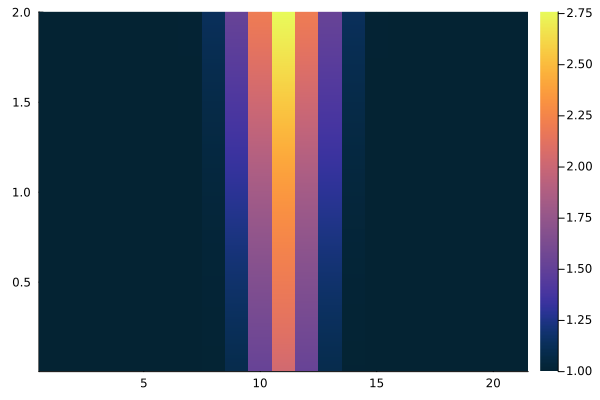

In [18]:
# Plot entanglement entropy of bonds between system + ancilla pairs:
gr()
S = reduce(vcat,transpose.(SvN))[:,1:2:(2*N)]
heatmap(1:N, times, S, c = :thermal)

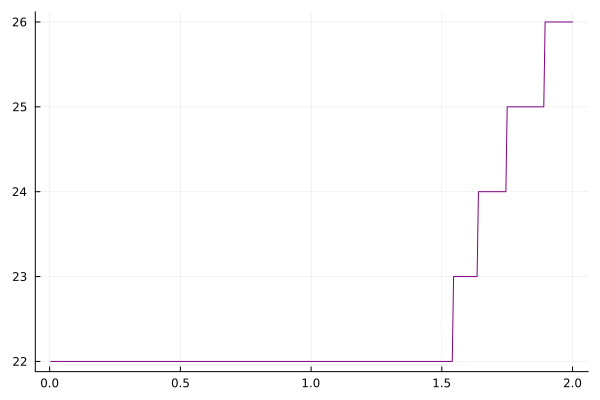

In [19]:
# Plot the growth in the maximum link dimension with time:
plot(times, chi, label=false, linecolor="purple")  
#scatter!(times, chi, label=false) 

In [20]:
C_r_t_5 = []
C_r_t_10 = []
C_r_t_20 = []
C_r_t_30 = []
C_r_t_40 = []
C_r_t_50 = []

two = BigFloat(2)
N_bf = BigFloat(N)

    for line in Commutator
        
        c_5 = 1/(two^N_bf)*line[1]
        c_10 = 1/(two^N_bf)*line[2] 
        c_20 = 1/(two^N_bf) * line[3]
        c_30 = 1/(two^N_bf) * line[4]
        c_40 = 1/(two^N_bf) * line[5]
        c_50 = 1/(two^N_bf) * line[6]

        push!(C_r_t_5, c_5)
        push!(C_r_t_10, c_10)
        push!(C_r_t_20, c_20)
        push!(C_r_t_30, c_30)
        push!(C_r_t_40, c_40)
        push!(C_r_t_50, c_50)
    end;

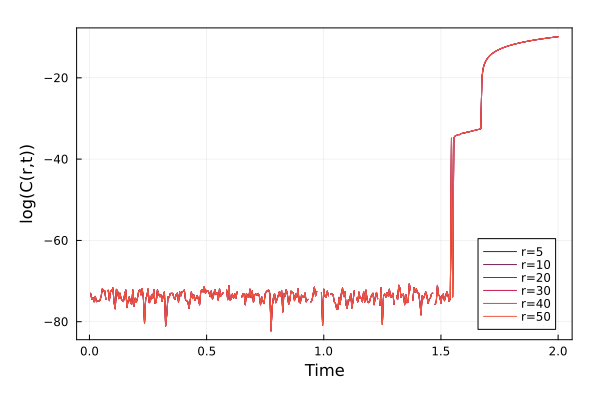

In [21]:


plot(times,log.(C_r_t_5), label="r=5", left_margin=20px,top_margin = 20px,
right_margin=20px, bottom_margin = 20px, framestyle=:box, linecolor=get(ColorSchemes.seaborn_rocket_gradient,0.2))#, ylim=(min_y, 20)) #, ylim=(min_y, 20)
#scatter!(times,log.(C_r_t_2), ylim=(min_y, 20))
plot!(times,log.(C_r_t_10), label="r=10", linecolor=get(ColorSchemes.seaborn_rocket_gradient,0.3))#, ylim=(min_y, 20)) #!
#scatter!(times,log.(C_r_t_4), ylim=(min_y, 20))
plot!(times,log.(C_r_t_20), label="r=20", linecolor=get(ColorSchemes.seaborn_rocket_gradient, 0.4))#, ylim=(min_y, 20))
#scatter!(times,log.(C_r_t_6), ylim=(min_y, 20))
plot!(times,log.(C_r_t_30), label="r=30", linecolor=get(ColorSchemes.seaborn_rocket_gradient, 0.5))#, ylim=(min_y, 20))

plot!(times,log.(C_r_t_40), label="r=40", linecolor=get(ColorSchemes.seaborn_rocket_gradient,0.6))#, ylim=(min_y, 20))

plot!(times,log.(C_r_t_50), label="r=50", linecolor=get(ColorSchemes.seaborn_rocket_gradient, 0.65))#, ylim=(min_y, 20))

xlabel!("Time")
ylabel!("log(C(r,t))")
# long time steps until time = 3.0
# short between time = 3.0 and 5.0
# long after time = 5.0